In [1]:
%gui qt
%matplotlib notebook

import pickle
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import pdb
import KF2D
import os
import matplotlib.pyplot as plt


KF2D.py:121: SyntaxWarning: name 'trans_mat' is assigned to before global declaration
  global trans_mat, trans_cov, init_cond


In [91]:
#For csv files
red = pd.read_csv('~/BehaviorVids/81/81_2rpm_red-1.csv',delimiter=',',header=0)
yellow = pd.read_csv('~/BehaviorVids/81/81_2rpm_yellow-1.csv',delimiter=',',header=0)
#'~/BehaviorVids/90/yellow-750-1000.csv'
len(red),len(yellow)
#filename = 

(2247, 2247)

In [92]:
#For csv-read (Physlet) files. 
for i in range(1,len(red)):
    redmat.append([red['x'][i],red['y'][i]])
yellowmat=[]
for i in range(1,len(yellow)):
    yellowmat.append([yellow['x'][i],yellow['y'][i]])
    

In [2]:
#For pickle files
os.chdir('/Volumes/ADIPOSE/90/')#'/Users/sazamore/BehaviorVids/90')

data_pd = pd.read_pickle('90_02rpm_170201_early.p')

red_pd = data_pd['red']
yellow_pd = data_pd['yellow']#.as_matrix()

In [3]:
#for pickle (autotracker) files
redmat=[]
yellowmat = []
for i in range(len(red_pd)):
    row = red_pd[i]
    #red += [[row[0][0],row[0][1], row[1]]]
    redmat += [[row[0],row[1]]]#, row[2][0]]]

for row in yellow_pd:
    #yellow += [[row[0][0],row[0][1], row[1]]]
    yellowmat += [[row[0],row[1]]]#, row[2][0]]]

red_pd = pd.DataFrame(red_pd, columns = ['x','y','frame'])
yellow_pd = pd.DataFrame(yellow_pd, columns = ['x','y','frame'])

In [30]:
red_kf = KF2D.fill_in_data(redmat)
yellow_kf = KF2D.fill_in_data(yellowmat)
len(red_kf[0]),len(yellow_kf[0])

AttributeError: 'list' object has no attribute 'as_matrix'

In [7]:
#Reworking KF. All changes should be in KF2D.py
smoothness = 700
sample = np.array(redmat)

#mask missing values
observations = np.ma.array(sample,mask=np.zeros(sample.shape))
missing_loc = np.where(np.isnan(sample))
if not missing_loc:
    observations[missing_loc[0][:],missing_loc[1][:]] = np.ma.masked

#Import Kalman filter, inerpolate missing points and get 2nd, 3rd orde kinematics
dt = 1./25	#Length of each frame (should be iether 1/25 or 1/30)	
n_timesteps = len(sample)
observation_matrix = np.array([[1,0,0,0],
                               [0,1,0,0]])#np.eye(4) 
t = np.linspace(0,len(observations)*dt,len(observations))
q = np.cov(observations.T[:2,:400])
qdot = np.cov(np.diff(observations.T[:2,:400]))#np.cov(observations[:1,:400])

h=(t[-1]-t[0])/t.shape[0]
A=np.array([[1,0,h,.5*h**2], 
                 [0,1,0,h],  
                 [0,0,1,0],
                 [0,0,0,1]])  

init_mean = [sample[0],0,0]
observation_covariance = q*smoothness  #ADJUST THIS TO CHANGE SMOOTHNESS OF FILTER
init_cov = np.eye(4)*.001#*0.0026
transition_matrix = A
transition_covariance = np.array([[q[0,0],q[0,1],0,0],
                                  [q[1,0],q[1,1],0,0],
                                  [0,0,qdot[0,0],qdot[0,1]],
                                  [0,0,qdot[1,0],qdot[1,1]]])
kf = KalmanFilter(transition_matrix, observation_matrix,transition_covariance,observation_covariance,n_dim_obs=2)

kf = kf.em(observations,n_iter=2,em_vars=['transition_covariance','transition_matrix','observation_covariance'])#,em_vars=['transition_covariance','initial_state_covariance','observation_matrix'])


In [8]:
red_kf = kf.filter(observations)[0]
sm_red= kf.smooth(observations)[0]


In [5]:
yellow_kf = kf.filter(observations)[0]
sm_yellow = kf.smooth(observations)[0]
y_obs = observations

<IPython.core.display.Javascript object>


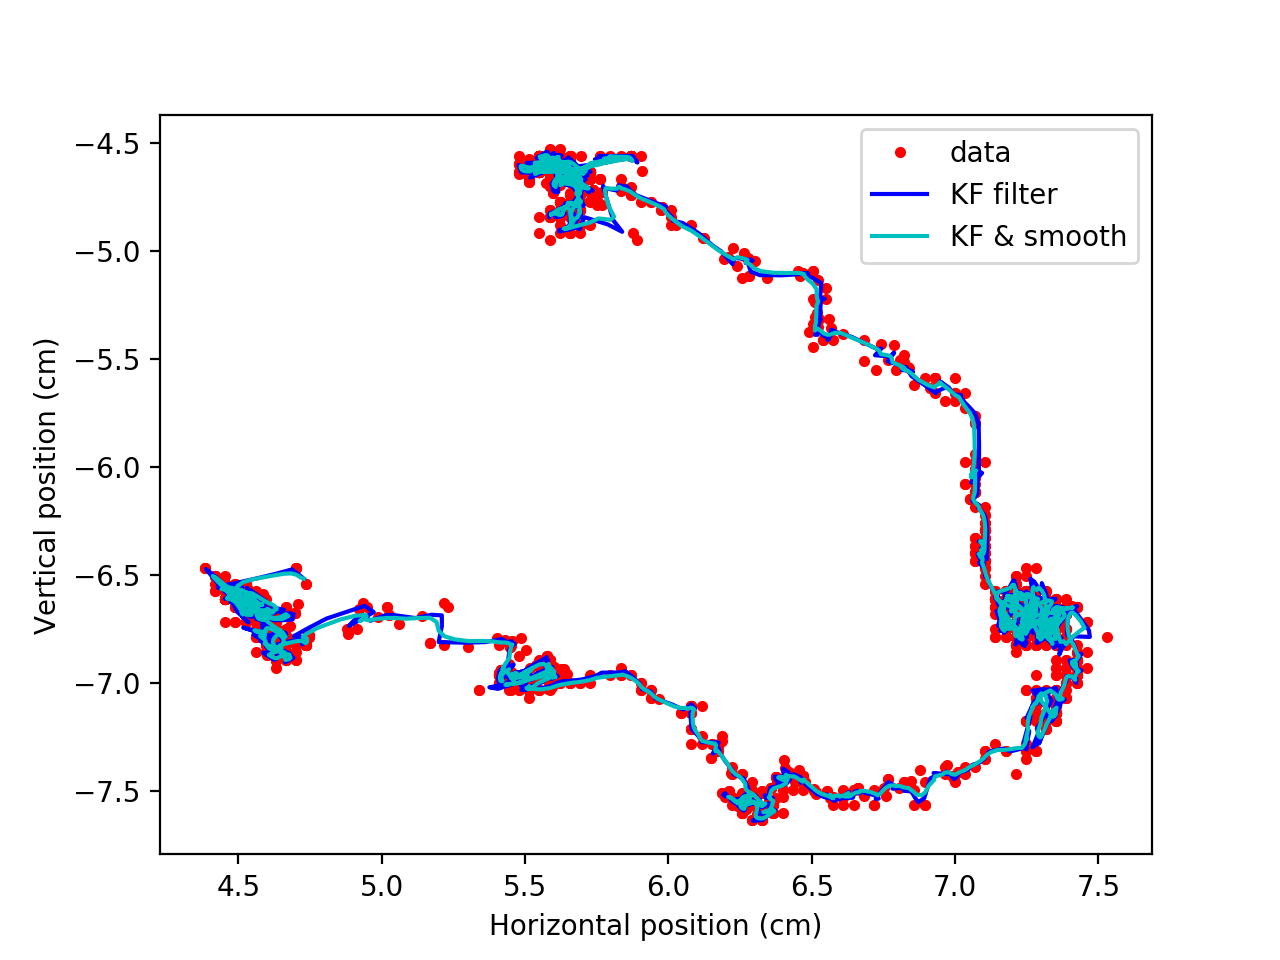

In [9]:
#Plot to compare RED raw data to KF and KF-smoothed.
plt.figure()

plt.plot(observations.T[0,:],observations.T[1,:],'r.', label='data')
plt.plot(red_kf[:,0],red_kf[:,1],'b-',label='KF filter'),
plt.plot(sm_red[:,0],sm_red[:,1],'c-',label='KF & smooth'),

plt.legend()
plt.xlabel('Horizontal position (cm)')
plt.ylabel('Vertical position (cm)')
plt.show()

<IPython.core.display.Javascript object>


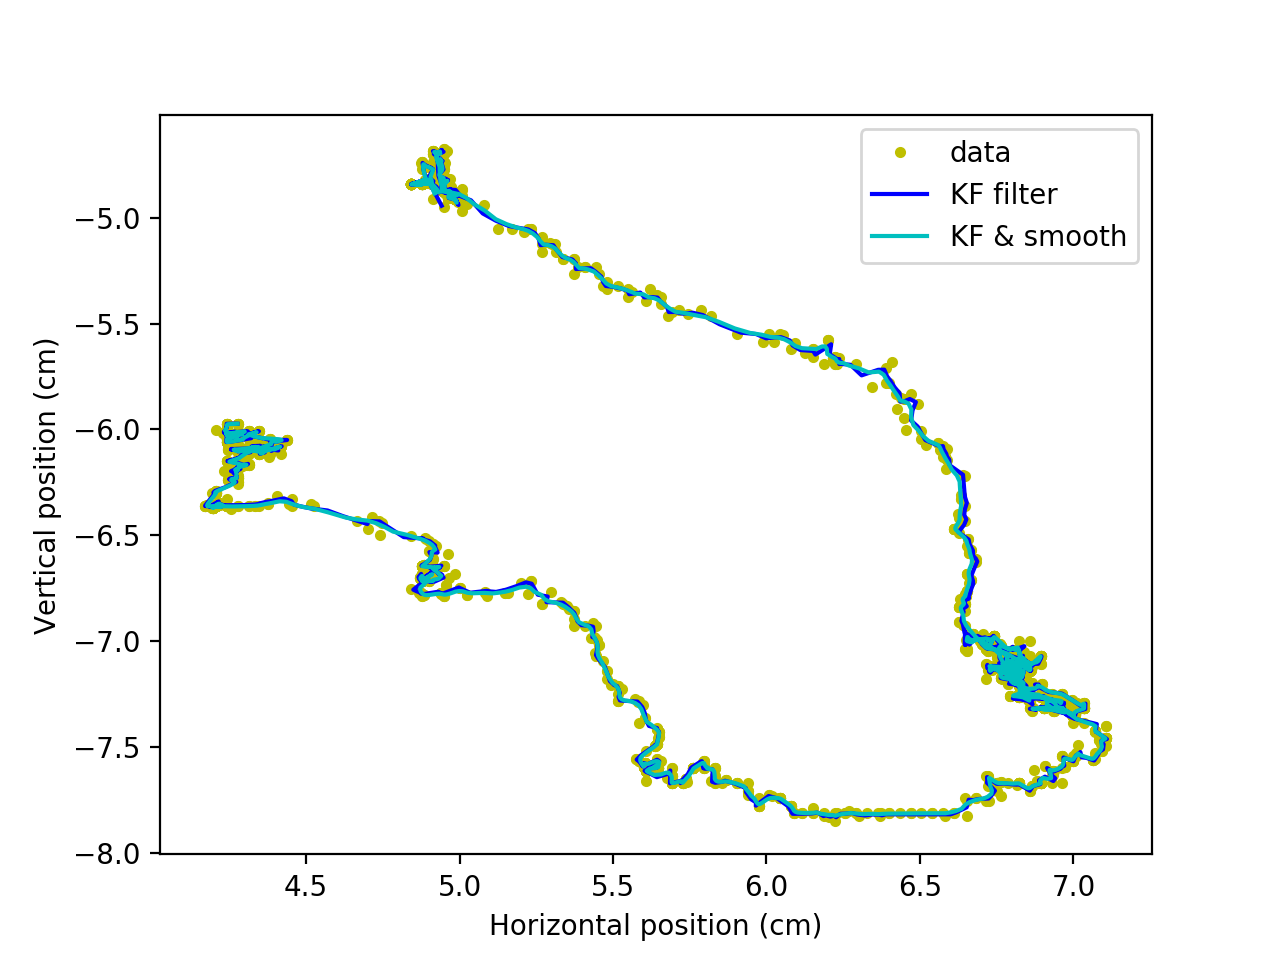

In [6]:
#Plot to compare YELLOW raw data to KF and KF-smoothed.
plt.figure()

plt.plot(y_obs.T[0,:],y_obs.T[1,:],'y.', label='data')
plt.plot(yellow_kf[:,0],yellow_kf[:,1],'b-',label='KF filter'),
plt.plot(sm_yellow[:,0],sm_yellow[:,1],'c-',label='KF & smooth'),

plt.legend()
plt.xlabel('Horizontal position (cm)')
plt.ylabel('Vertical position (cm)')
plt.show()

<IPython.core.display.Javascript object>


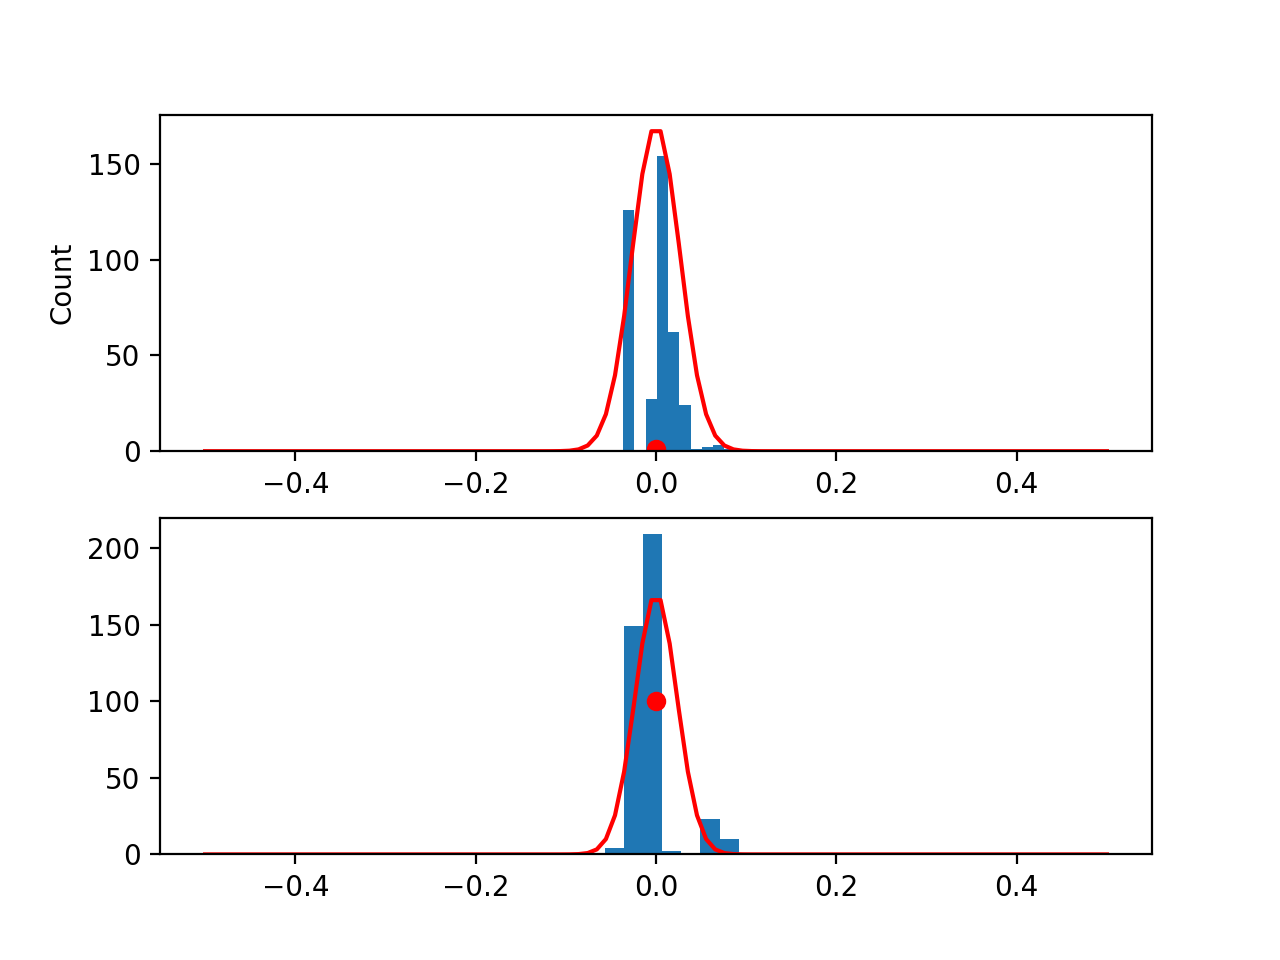

In [147]:
#Determine if noise is Guassian (can we use KF)
from scipy.optimize import curve_fit

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mu = 0#np.mean(observations.T[0,:400])
sig = np.std(observations.T[0,:400])

def gauss (x, mu, sig):
    #p = [x0, y0, sigma]
    return np.exp(-(x-mu)**2 / (2 * sig**2))

h,n = np.histogram(observations.T[0,:400]-np.mean(observations.T[0,:400]))
fit = curve_fit(gauss, n[1:],h)

plt.figure()
plt.subplot(211)
plt.hist(observations.T[0,:400]-np.mean(observations.T[0,:400]))
plt.plot(np.linspace(-.5,.5,num=100),170*gaussian(np.linspace(-.5,.5,num=100), mu, sig),'r')
plt.plot(mu, gaussian(mu,mu,sig),'ro')#np.mean(observations.T[0,:400]),0,'ro')
plt.ylabel('Count')

mu = 0#np.mean(observations.T[1,:400])
sig = np.std(observations.T[1,:400])

plt.subplot(212)
plt.hist(observations.T[1,:400]-np.mean(observations.T[1,:400]))
plt.plot(np.linspace(-0.5,0.5,num=100),170*gaussian(np.linspace(-0.5,0.5,num=100), mu, sig),'r')
plt.plot(0,100,'ro')
plt.show()

In [115]:
observations.T[0,:400]

masked_array(data = [12.04 12.04 12.04 12.04 12.04 12.04 12.04 12.04 12.04 12.04 12.04 12.04
 12.05 12.08 12.09 12.09 12.09 12.1 12.11 12.12 12.13 12.1 12.1 12.11 12.12
 12.13 12.13 12.14 12.16 12.18 12.18 12.19 12.19 12.19 12.18 12.18 12.18
 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18
 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18
 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18 12.18
 12.18 12.18 12.18 12.17 12.18 12.18 12.18 12.18 12.18 12.37 12.35 12.35
 12.35 12.35 12.35 12.35 12.35 12.35 12.35 12.35 12.35 12.35 12.36 12.35
 12.36 12.36 12.35 12.35 12.36 12.36 12.39 12.43 12.45 12.45 12.45 12.46
 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.46 12.45 12.45
 12.45 12.45 12.46 12.45 12.45 12.48 12.49 12.49 12.49 12.5 12.49 12.5 12.5
 12.5 12.5 12.5 12.49 12.49 12.49 12.49 12.49 12.49 12.49 12.56 12.55 12.55
 12.55 12.55 12.55 12.55 12.55 12.55 12.55 12.55 12.55 12.55 12.55 12.56
 12.55 12.56 12.56 12.

<IPython.core.display.Javascript object>


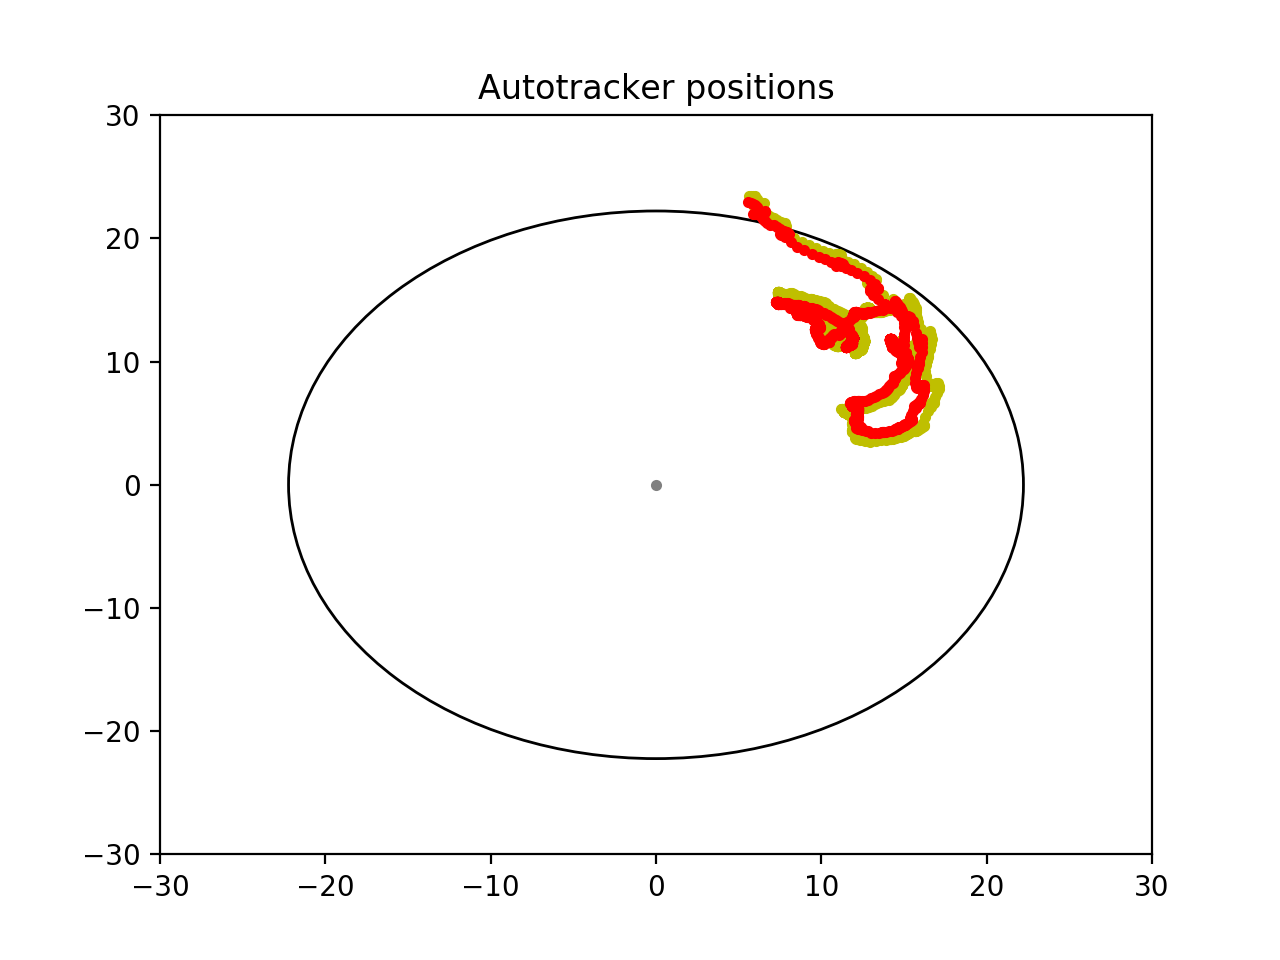

In [129]:
#Plot to look at raw tracked points.
fig = plt.figure()
ax = plt.axes()

plt.plot(yellow['x'],yellow['y'],'y.',red['x'],red['y'],'r.')
plt.plot(0,0,'.',color='gray')

circ1 = plt.Circle((0,0),44.45/2,color='k',fill=False)
ax.add_artist(circ1)
plt.title('Autotracker positions')

plt.xlim(-30,30)
plt.ylim(-30,30)
plt.show()

In [152]:
red_kf

array([[ 5.56278125, -4.6498809 ,  0.        ,  0.        ],
       [ 5.50766548, -4.59037175, -0.2563022 ,  0.36470121],
       [ 5.5319688 , -4.58838626, -0.02844282,  0.28926901],
       ..., 
       [ 4.69422405, -6.47136832,  0.13965269,  0.10305187],
       [ 4.72034622, -6.50422794,  0.15335942,  0.07331042],
       [ 4.73243237, -6.52085425,  0.15675779,  0.05727846]])

In [10]:
if len(red_kf[0])!=len(yellow_kf[0]):
    print("Lengths don't match. Aborting!")
else:

#determine frames and times (all videos are 25 fps)
#     frames = red_kf[1]
#     frames = np.linspace(frames[0],frames[-1],frames[-1]-frames[0]+1)
#     frames = frames[:len(frames)]
    frames = range(100,len(red_kf)+100)
    print(len(frames))

    rot_dir = input('Enter rotation direction: CW or CCW. ')
    
    #TODO: improve this
    T = []
    rotation = []
    for row in red_kf.T[0]:
        T.append(row/25)
        rotation.append(rot_dir)

    #KF output columns are: x,y,dx,dy
    try:
        raw_data = np.column_stack((red_kf, yellow_kf, frames, rotation))
    except:
        print ('Red_kf, yellow_kf, frames, and rotation are not all the same lenght. Fix and retry.')
#     raw_data = np.column_stack((red_pred[0][:,0].T,red_pred[0][:,1].T,red_pred[0][:,2].T,red_pred[0][:,3].T,\
#                        yellow_pred[0][:,0].T,yellow_pred[0][:,1].T,yellow_pred[0][:,2].T,yellow_pred[0][:,3].T,\
#                        frames,rotation))
    raw_pd = pd.DataFrame(raw_data, columns = ['red_x','red_y','red x vel','red y vel','yellow_x',\
                                 'yellow_y','yellow x vel','yellow y vel','frames','rotation_direction'])

    filename = input("Enter entire file name with extension. Format = 'ID_SPDrpm_DATE_raw.p': ")

    raw_pd.to_pickle(filename)
    print('File saved!')

2401
Enter rotation direction: CW or CCW. 'CCW'
Enter entire file name with extension. Format = 'ID_SPDrpm_DATE_raw.p': '90_02rpm_170201_early_raw.p'
File saved!


In [166]:
len(red_kf), len(yellow_kf), len(frames),len(rotation)

(2401, 2401, 2401, 2401)

In [169]:
data_pd.to_pickle('90_02rpm_170201_early.p')